In [7]:
import re
import requests

BASE_DIR = "https://opendata.dwd.de/weather/nwp/icon-eu/grib/00/rain_gsp/"

r = requests.get(BASE_DIR, timeout=60)
r.raise_for_status()
html = r.text

files = re.findall(r'href="([^"]+\.*)"', html)
files = sorted(set(files))

print(f"Directory: {BASE_DIR}")
print(f"Found {len(files)} GRIB2 files:\n")

for f in files:
    print(f)


Directory: https://opendata.dwd.de/weather/nwp/icon-eu/grib/00/rain_gsp/
Found 94 GRIB2 files:

../
icon-eu_europe_regular-lat-lon_single-level_2026011200_000_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_001_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_002_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_003_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_004_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_005_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_006_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_007_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_008_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_009_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-level_2026011200_010_RAIN_GSP.grib2.bz2
icon-eu_europe_regular-lat-lon_single-leve

In [18]:
import bz2
import requests
from pathlib import Path

BASE_DIR = "https://opendata.dwd.de/weather/nwp/icon-eu/grib/00/rain_gsp/"
OUTDIR = Path("icon_eu_slide_data")
OUTDIR.mkdir(exist_ok=True)

def download(url: str, outpath: Path):
    if outpath.exists() and outpath.stat().st_size > 100_000:
        print("Already have:", outpath.name)
        return outpath
    print("Downloading:", url)
    r = requests.get(url, timeout=180)
    r.raise_for_status()
    outpath.write_bytes(r.content)
    print("Saved:", outpath.name, f"({outpath.stat().st_size/1e6:.2f} MB)")
    return outpath

def bunzip2_file(bz2_path: Path) -> Path:
    grib_path = bz2_path.with_suffix("")  # remove .bz2
    if grib_path.exists() and grib_path.stat().st_size > 100_000:
        print("Already unzipped:", grib_path.name)
        return grib_path
    print("Unzipping:", bz2_path.name)
    data = bz2.decompress(bz2_path.read_bytes())
    grib_path.write_bytes(data)
    print("Wrote:", grib_path.name, f"({grib_path.stat().st_size/1e6:.2f} MB)")
    return grib_path

# Run timestamp from your listing
run = "2026011200"

# ------------------------------------------------------------
# We want 1-hour rain at lead 001 and at lead 048.
# Since RAIN_GSP is accumulated, we need 047 and 048 to compute:
#   rain_48_1h = acc048 - acc047
# ------------------------------------------------------------

f1_bz2  = f"icon-eu_europe_regular-lat-lon_single-level_{run}_001_RAIN_GSP.grib2.bz2"
f47_bz2 = f"icon-eu_europe_regular-lat-lon_single-level_{run}_047_RAIN_GSP.grib2.bz2"
f48_bz2 = f"icon-eu_europe_regular-lat-lon_single-level_{run}_048_RAIN_GSP.grib2.bz2"

p1_bz2  = OUTDIR / f1_bz2
p47_bz2 = OUTDIR / f47_bz2
p48_bz2 = OUTDIR / f48_bz2

download(BASE_DIR + f1_bz2,  p1_bz2)
download(BASE_DIR + f47_bz2, p47_bz2)
download(BASE_DIR + f48_bz2, p48_bz2)

p1  = bunzip2_file(p1_bz2)
p47 = bunzip2_file(p47_bz2)
p48 = bunzip2_file(p48_bz2)

print("\nREADY:")
print(" lead001:", p1)
print(" lead047:", p47)
print(" lead048:", p48)


Already have: icon-eu_europe_regular-lat-lon_single-level_2026011200_001_RAIN_GSP.grib2.bz2
Downloading: https://opendata.dwd.de/weather/nwp/icon-eu/grib/00/rain_gsp/icon-eu_europe_regular-lat-lon_single-level_2026011200_047_RAIN_GSP.grib2.bz2
Saved: icon-eu_europe_regular-lat-lon_single-level_2026011200_047_RAIN_GSP.grib2.bz2 (0.51 MB)
Already have: icon-eu_europe_regular-lat-lon_single-level_2026011200_048_RAIN_GSP.grib2.bz2
Already unzipped: icon-eu_europe_regular-lat-lon_single-level_2026011200_001_RAIN_GSP.grib2
Unzipping: icon-eu_europe_regular-lat-lon_single-level_2026011200_047_RAIN_GSP.grib2.bz2
Wrote: icon-eu_europe_regular-lat-lon_single-level_2026011200_047_RAIN_GSP.grib2 (1.81 MB)
Already unzipped: icon-eu_europe_regular-lat-lon_single-level_2026011200_048_RAIN_GSP.grib2

READY:
 lead001: icon_eu_slide_data/icon-eu_europe_regular-lat-lon_single-level_2026011200_001_RAIN_GSP.grib2
 lead047: icon_eu_slide_data/icon-eu_europe_regular-lat-lon_single-level_2026011200_047_RAIN_G

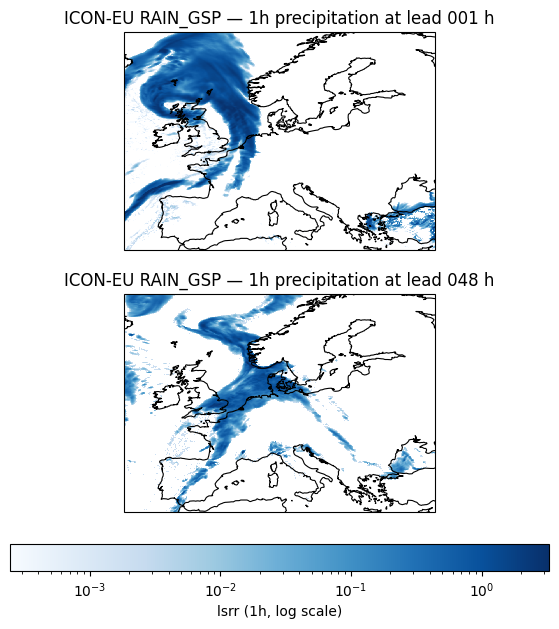

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import LogNorm

def open_grib(path):
    return xr.open_dataset(path, engine="cfgrib", backend_kwargs={"indexpath": ""})

# Load accumulated precipitation at lead 001, 047, 048
ds1  = open_grib(p1)
ds47 = open_grib(p47)
ds48 = open_grib(p48)

vname = list(ds1.data_vars)[0]
acc1  = ds1[vname]
acc47 = ds47[vname]
acc48 = ds48[vname]

# Convert accumulated to 1-hour precipitation:
# hour 1:  acc(1)  - acc(0)  (acc0 is zero) => acc1
# hour 48: acc(48) - acc(47)
rain1  = acc1
rain48 = acc48 - acc47

# coordinate names
lat_name = "latitude" if "latitude" in rain1.coords else "lat"
lon_name = "longitude" if "longitude" in rain1.coords else "lon"

extent = [-15, 35, 35, 70]

# build LogNorm scale from BOTH 1h fields
vals = np.concatenate([rain1.values.ravel(), rain48.values.ravel()])
vals = vals[np.isfinite(vals)]
vals = vals[vals > 0]

if len(vals) == 0:
    raise RuntimeError("All 1h rain values are zero/NaN.")

vmin = max(1e-4, float(np.nanpercentile(vals, 5)))
vmax = float(np.nanpercentile(vals, 99.5))
norm = LogNorm(vmin=vmin, vmax=vmax)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(11, 7))

for i, (lead, da) in enumerate([(1, rain1), (48, rain48)], start=1):
    ax = fig.add_subplot(2, 1, i, projection=proj)
    ax.set_extent(extent, crs=proj)
    ax.coastlines(resolution="50m", linewidth=0.8)

    im = ax.pcolormesh(
        da[lon_name], da[lat_name], da.values,
        transform=proj,
        norm=norm,
        cmap="Blues"
    )

    ax.set_title(f"ICON-EU RAIN_GSP — 1h precipitation at lead {lead:03d} h", fontsize=12)

cbar = fig.colorbar(im, ax=fig.axes, orientation="horizontal", pad=0.06, fraction=0.05)
cbar.set_label(f"{vname} (1h, log scale)")

plt.savefig("weather_t1_t48_rain_gsp_1honly_europe.png", dpi=220)
plt.show()


Available leads (last 15): [78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120]
Valid 1h leads (last 15): [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]

Chosen leads (1h-only): [1, 12, 24, 36, 48, 60, 72, 78]
Need leads to download: [0, 1, 11, 12, 23, 24, 35, 36, 47, 48, 59, 60, 71, 72, 77, 78]
Download: icon-eu_europe_regular-lat-lon_single-level_2026011200_000_RAIN_GSP.grib2.bz2
Download: icon-eu_europe_regular-lat-lon_single-level_2026011200_001_RAIN_GSP.grib2.bz2
Download: icon-eu_europe_regular-lat-lon_single-level_2026011200_011_RAIN_GSP.grib2.bz2
Download: icon-eu_europe_regular-lat-lon_single-level_2026011200_012_RAIN_GSP.grib2.bz2
Download: icon-eu_europe_regular-lat-lon_single-level_2026011200_023_RAIN_GSP.grib2.bz2
Download: icon-eu_europe_regular-lat-lon_single-level_2026011200_024_RAIN_GSP.grib2.bz2
Download: icon-eu_europe_regular-lat-lon_single-level_2026011200_035_RAIN_GSP.grib2.bz2
Download: icon-eu_europe_regular-lat-lon_single-level_2026

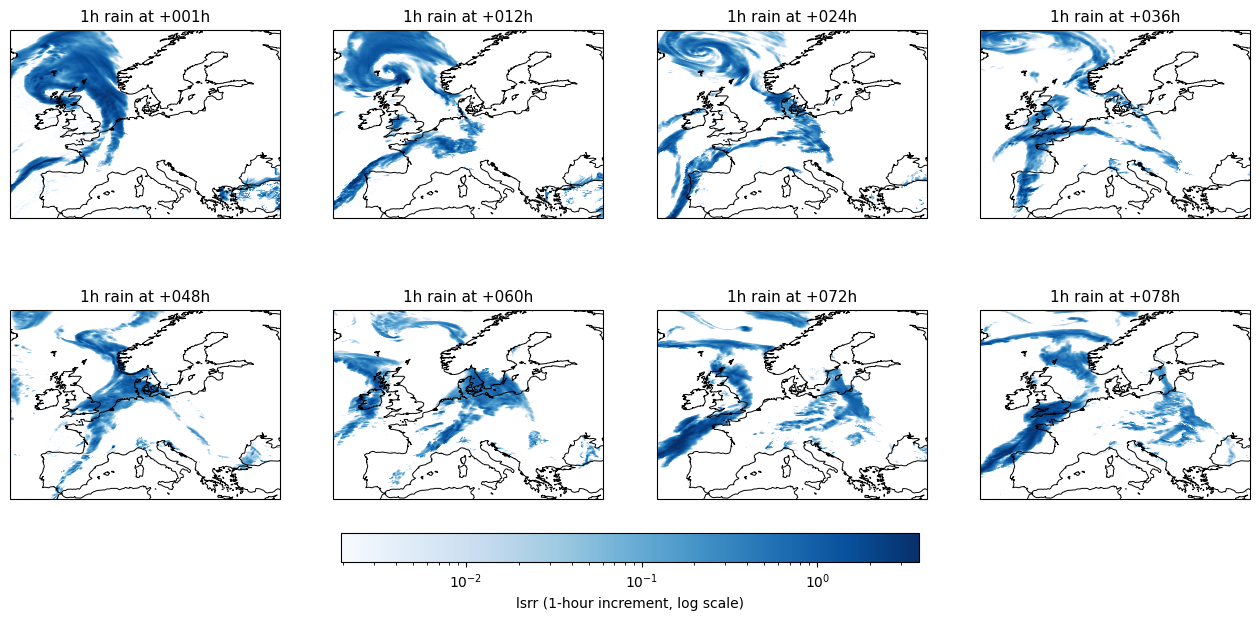

Saved: rain_gsp_1h_2x4_panels.png


In [26]:
import re
import bz2
import requests
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import LogNorm

# ============================================================
# ICON-EU RAIN_GSP: 1-hour precipitation only (2x4 panels)
# ============================================================

BASE_DIR = "https://opendata.dwd.de/weather/nwp/icon-eu/grib/00/rain_gsp/"
OUTDIR = Path("icon_eu_slide_data")
OUTDIR.mkdir(exist_ok=True)

run = "2026011200"
TARGET_LEADS = [1, 12, 24, 36, 48, 60, 72, 84]  # will be snapped to VALID 1h leads
extent = [-15, 35, 35, 70]  # Europe

def get_listing(url: str) -> str:
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    return r.text

def download(url: str, outpath: Path):
    if outpath.exists() and outpath.stat().st_size > 100_000:
        return outpath
    r = requests.get(url, timeout=240)
    r.raise_for_status()
    outpath.write_bytes(r.content)
    return outpath

def bunzip2_file(bz2_path: Path) -> Path:
    grib_path = bz2_path.with_suffix("")  # remove ".bz2"
    if grib_path.exists() and grib_path.stat().st_size > 100_000:
        return grib_path
    grib_path.write_bytes(bz2.decompress(bz2_path.read_bytes()))
    return grib_path

def open_grib(path: Path):
    return xr.open_dataset(path, engine="cfgrib", backend_kwargs={"indexpath": ""})

# ------------------------------------------------------------
# 1) Parse listing and build available leads for this run
# ------------------------------------------------------------
html = get_listing(BASE_DIR)
files = sorted(set(re.findall(r'href="([^"]+\.grib2\.bz2)"', html)))

pat = re.compile(rf"icon-eu_europe_regular-lat-lon_single-level_{run}_(\d{{3}})_RAIN_GSP\.grib2\.bz2$")
fname_for = {}
avail = []
for f in files:
    m = pat.match(f)
    if m:
        L = int(m.group(1))
        avail.append(L)
        fname_for[L] = f
avail = sorted(set(avail))

if not avail:
    raise RuntimeError("No files matched this run. Check 'run' string.")

# VALID leads for 1-hour increments: need L and L-1
valid = sorted([L for L in avail if (L >= 1 and (L-1) in avail)])
if len(valid) < 8:
    raise RuntimeError(f"Not enough 1-hour leads available (found {len(valid)}).")

print("Available leads (last 15):", avail[-15:])
print("Valid 1h leads (last 15):", valid[-15:])

# ------------------------------------------------------------
# 2) Snap targets to valid leads (nearest valid lead)
# ------------------------------------------------------------
def snap_to_valid(L):
    return min(valid, key=lambda a: abs(a - L))

LEADS = []
for L in TARGET_LEADS:
    s = snap_to_valid(L)
    if s not in LEADS:
        LEADS.append(s)

# ensure exactly 8 panels (fill from valid if duplicates occurred)
if len(LEADS) < 8:
    for L in valid:
        if L not in LEADS:
            LEADS.append(L)
        if len(LEADS) == 8:
            break

LEADS = LEADS[:8]
print("\nChosen leads (1h-only):", LEADS)

# ------------------------------------------------------------
# 3) Download only what is needed: L and L-1 for all chosen leads
# ------------------------------------------------------------
need = sorted(set(LEADS + [L-1 for L in LEADS]))
print("Need leads to download:", need)

grib_paths = {}
for L in need:
    fname = fname_for[L]
    bz2_path = OUTDIR / fname
    print("Download:", fname)
    download(BASE_DIR + fname, bz2_path)
    grib_paths[L] = bunzip2_file(bz2_path)

# ------------------------------------------------------------
# 4) Load accumulated and compute 1-hour precipitation (NO FALLBACKS)
# ------------------------------------------------------------
acc = {}
for L in need:
    ds = open_grib(grib_paths[L])
    vname = list(ds.data_vars)[0]
    acc[L] = ds[vname]

rain_1h = {L: (acc[L] - acc[L-1]) for L in LEADS}  # guaranteed valid

# coords
da_ref = rain_1h[LEADS[0]]
lat_name = "latitude" if "latitude" in da_ref.coords else "lat"
lon_name = "longitude" if "longitude" in da_ref.coords else "lon"

# ------------------------------------------------------------
# 5) Log scale
# ------------------------------------------------------------
vals = np.concatenate([rain_1h[L].values.ravel() for L in LEADS])
vals = vals[np.isfinite(vals)]
vals = vals[vals > 0]
if len(vals) == 0:
    raise RuntimeError("All 1h rain values are zero/NaN.")

vmin = max(1e-4, float(np.nanpercentile(vals, 5)))
vmax = float(np.nanpercentile(vals, 99.5))
norm = LogNorm(vmin=vmin, vmax=vmax)

# ------------------------------------------------------------
# 6) Plot 2x4 panels
# ------------------------------------------------------------
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(16, 7.5))

for i, L in enumerate(LEADS, start=1):
    ax = fig.add_subplot(2, 4, i, projection=proj)
    ax.set_extent(extent, crs=proj)
    ax.coastlines(resolution="50m", linewidth=0.7)

    da = rain_1h[L]
    im = ax.pcolormesh(
        da[lon_name], da[lat_name], da.values,
        transform=proj,
        norm=norm,
        cmap="Blues"
    )
    ax.set_title(f"1h rain at +{L:03d}h", fontsize=11)

cbar = fig.colorbar(im, ax=fig.axes, orientation="horizontal", pad=0.06, fraction=0.05)
cbar.set_label(f"{vname} (1-hour increment, log scale)")

outpng = "rain_gsp_1h_2x4_panels.png"
plt.savefig(outpng, dpi=220)
plt.show()
print("Saved:", outpng)
